# Enumération des carrés latins et grilles de sudoku
#### Bennaceur Mehdi, Marck Jérémy et Ané Benoit

## Introduction
Notre projet a pour ambition de trouver le nombre de carrés latins possibles pour une dimension donnée. Un carré latin est un tableau de $n$ lignes et $n$ colonnes remplies de $n$ éléments distincts où chaque ligne et chaque colonne ne contient qu'une seule fois l'élément $k \in [1,n]$. Le plus souvent, les $n$ éléments utilisés sont les entiers compris entre 0 et $n-1$. Le tableau suivant est un exemple de carré latin 4*4 : \begin{bmatrix}0&1&2&3\\1&2&3&0\\2&3&0&1\\3&0&1&2\\\end{bmatrix}


Le problème de l'énumération des grilles possibles est que le nombre de possibilités explosent rapidement et qu'il n'y a pas de formule simple pour calculer le nombre de cas envisageable. Nous pouvons donner les bornes du nombre de carrés latins possibles $\displaystyle L_{k}$ : $\displaystyle \prod_{i=1}^{k}\left(i!\right)^{k/i}\geq L_{k}\geq {\frac {\left(k!\right)^{2k}}{k^{k^{2}}}}$.

On peut montrer que cette énumération est un problème NP complet.
La solution la plus grande résolue de manière exacte à cette date est de taille 11 et a environ $7.77×10^{47}$ solutions.
(Ce problème reste un point de recherche encore aujourd'hui dans la mesure où il est impossible de donner l'ensemble des cas possibles pour une dimension supérieure ou égale à 12).

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image

Pour comparer dans la suite nos estimateurs aux bornes théoriques écrites plus haut, on code ci dessous une fonction permettant de les obtenir. 

In [0]:
def bornes(k):
    inf = (math.factorial(k)**(2*k))/(k**(k**2))
    sup = 1
    for i in range(1, k+1):
        sup = sup * (math.factorial(i)**(k/i))
    return inf, sup

In [0]:
for k in range(1, 12):
    print(bornes(k))

(1.0, 1.0)
(1.0, 2.0)
(2.3703703703703702, 16.970562748477143)
(25.62890625, 1046.6614614713121)
(2077.6019874734407, 714396.0391053179)
(1881676.4231589208, 7621831476.457839)
(26559723502.564575, 1704118412100761.2)
(7772651709434129.0, 1.0302647256244118e+22)
(6.054681844500374e+22, 2.1102332772164454e+30)
(1.5676916946577623e+31, 1.792518110238015e+40)
(1.6478242606843205e+41, 7.585175356413695e+51)


# Méthodes de calculs et Protocoles

**Quelques notations** 

- $L_{k}$ : Espace des carrés latins pour une taille $k$ et $C_{k} = |L_{k}|$.

- $H_{k}$ : Espace des matrices carrées de taille $k$ telles que chaque ligne est une permutation de $\{1, \dots, k\}$ et $P_{k} = |H_{k}|$.

Notons que $L_{k} \subset H_{k}$ et que $P_{k} = k!^{k}$. Notre objectif est d'approximer $C_{k}$. Nous verrons plus tard comment échantilloner à partir de $H_{k}$.

- $S(M)$ : Fonction de pénalité telle que $\forall M \in H_{k}$, $\displaystyle{S(M) = \sum_{Colonnes M_{c}} (k - n_{unique}(M_{c}))}$ où $n_{unique}(M_{c})$ est le nombre de valeurs uniques dans la colonne $M_{c}$. En d'autres termes, nous regardons le nombre de chiffres différents entre toutes les paires de colonnes de M. Remarquons que $S(M) = 0 \iff M \in L_{k}$. 
 
Maintenant, en utlisant le cours de MCMC (SMCsamplers, Chapitre 10 SMC), nous pouvons définir $V(\lambda) = \displaystyle{\sum_{M \in H_{k}}} e^{-\lambda \cdot S(M)}$.

Nous pouvons voir la valeur $e^{-\lambda \cdot S(M)}$ comme le poids $w_{t}^n$ du cours.

Nous remarquons immédiatement que $V(0) = P_{k}$ et $\displaystyle{\lim_{\lambda\to\infty} V(\lambda) = C_{k}}$. Une méthode d'estimation de $C_{k}$ pourrait être d'estimer $\hat{p_{k}} := \displaystyle{\lim_{\lambda\to\infty}} E[e^{-\lambda \cdot S(M)}]$ pour $M \in H_{k}$. Cette valeur correspond à la proportion de carrés latins dans $H_{k}$. Nous pouvons ainsi déduire $C_{k} = \hat{p_{k}} \cdot P_{k}$. 
Nous avons implémenté cette méthode et, comme on aurait pu imaginer, nous voyons que cette méthode produit de grosses erreurs avec de grandes dimensions (même pour des petites) en raison de la forte différence entre $C_{k}$ et $P_{k}$.


**Avantage du tempering par rapport au monte carlo**

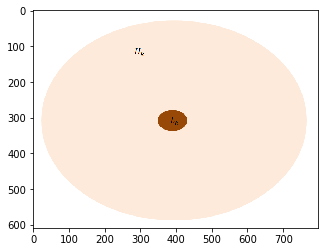

In [11]:
img = Image.open('mc.PNG')
plt.imshow(img)

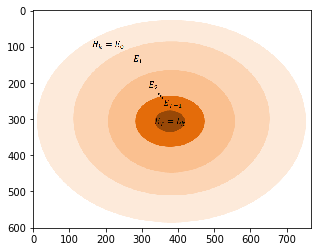

In [12]:
img = Image.open('tempering.PNG')
plt.imshow(img)

# Approche naïve

Elle se présente de la façon suivante : 
* 1) Tirons N matrices de $H_{k}$ : chaque ligne comme une permutation de {1...k} et indépendante les unes des autres. On négligera la contrainte sur les colonnes. 
* 2)
*   Pour n = 1,...,N (Pour chaque matrice générée $M_{n}$):  
      * 1) Calculer $U_n$ de chaque matrice avec la formule $ U_n = e^{-\lambda \times  S(M_n)}$ 
      * 2) Calculer la proportion de carrés latins via $\hat{p} = \frac{1}{N}\displaystyle{\sum_{n = 1}^N}U_n $ 
      
Ainsi, on obtient un estimateur avec le principe suivant : $\hat{C_k} = \hat{p}*P_k$

In [0]:
true_values = {2:2, 3:12, 4:576, 5:161280, 6:812851200, 7:61479419904000, 8:108776032459082956800, 9:5524751496156892842531225600,10:9982437658213039871725064756920320000, 
               11:776966836171770144107444346734230682311065600000}

def E(square):
    
    e = 0
    size = square.shape[0]
    for j in range(size):
        n_unique = len(set(square[:, j]))
        e += size - n_unique 
    return e

def naive_estimator(n, size, lbd):
    echant = [np.array(list(np.random.permutation(size) for i in range(size))) for n in range(n)]
    exp = []
    for mat in echant:
        exp.append(np.exp(-lbd*E(mat)))
    prop_hat = np.mean(exp)
    estimator = math.factorial(size)**size * prop_hat
    #print("Estimated :", estimator)
    #print("True value :", true_values[size])
    return estimator

def get_estimates_naive(n_iter, n, size, lbd):
    est = []
    for k in range(n_iter):
        l = naive_estimator(n, size, lbd)
        est.append(l)
    return est 

def viz_estimate_naive(est, dimension, true):
    plt.boxplot(est)
    plt.plot(1, true, marker='o', markersize=10, label='True value') 
    plt.legend()
    plt.title("Boxplot - Estimation naïve du nombre de carrés latins en dimension " + str(dimension), pad=20)
    plt.show()

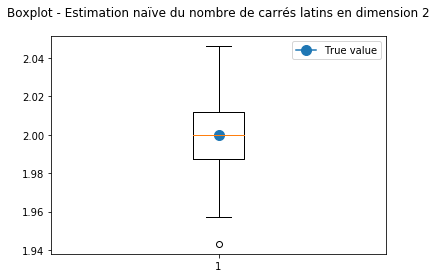

In [0]:
est = get_estimates_naive(100, 10000,  2, lbd=20)
viz_estimate_naive(est, 2, 2)

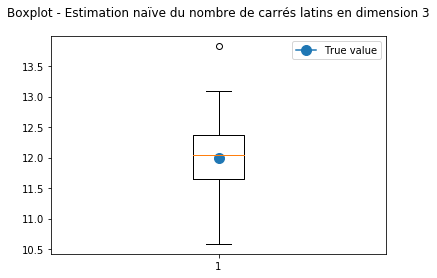

In [0]:
est = get_estimates_naive(100, 10000, 3, lbd=20)
viz_estimate_naive(est, 3, 12)

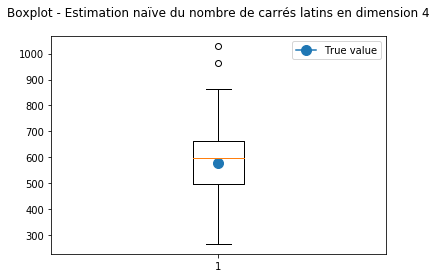

In [0]:
est = get_estimates_naive(100, 10000, 4, lbd=20)
viz_estimate_naive(est, 4, 576)

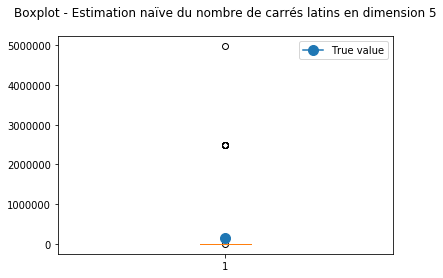

In [0]:
est = get_estimates_naive(100, 10000, 5, lbd=20)
viz_estimate_naive(est, 5, 161280)

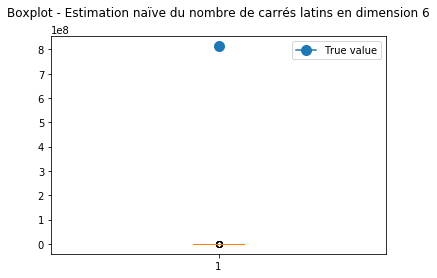

In [0]:
est = get_estimates_naive(100, 10000, 6, lbd=20)
viz_estimate_naive(est, 6, 812851200)

**Conclusion** 
On remarque que la méthode naïve est plutôt satisfaisant pour les petites dimensions mais ne fonctionne plus du tout à partir de $k = 5$. En effet, le nombre d'itérations commence à être trop petit au vu de la taille de l'espace échantillonné.


On peut aussi regarder la taille de l'espace echantilloné pour relativiser nos résultats.

In [0]:
hk = lambda x : math.factorial(x)**x

In [0]:
for k in range(2, 12):
    a = str(hk(k))
    n=3
    print([a[i:i+n] for i in range(0, len(a), n)])

['4']
['216']
['331', '776']
['248', '832', '000', '00']
['139', '314', '069', '504', '000', '000']
['826', '064', '112', '539', '035', '238', '400', '000', '00']
['698', '496', '424', '714', '151', '412', '362', '914', '037', '760', '000', '000', '0']
['109', '110', '688', '415', '571', '316', '480', '344', '899', '355', '894', '085', '582', '848', '000', '000', '000']
['395', '940', '866', '122', '425', '193', '243', '875', '570', '782', '668', '457', '763', '038', '822', '400', '000', '000', '000', '000', '000', '000']
['409', '933', '016', '554', '924', '328', '182', '440', '935', '903', '164', '918', '932', '547', '530', '146', '724', '293', '451', '448', '320', '000', '000', '000', '000', '000', '000', '000']


# Méthode de Tempering

**Méthodologie** 


Pour traîter le problème que nous venons d'illustrer, nous introduisons une séquences de distribution intermédiaires (comme présenté dans le cours et par Del Moral, 2006) quis ont "assez proches" entre eux. Plus particulièrement : 

Nous introduisons $0=\lambda_{1} < \lambda_{2} < \dots < \lambda_{T}$. Par la suite, nous avons $\frac{V(\lambda_{i})}{V(\lambda_{i-1})} = E[e^{-(\lambda_{i-1} - \lambda_{i}) \dot S}]$

Ces termes peuvent être calculés par simulation de Monte Carlo sans avoir le problème de savoir si les $\lambda_{i}$ sont suffisamment proches de façon à ce que les distributions soient aussi assez proches.

Pour obtenir notre estimateur final, nous utilisons le fait que $\frac{V(\lambda)}{V(0)} = \displaystyle{\prod_{i}} \frac{V(\lambda_{i})}{V(\lambda_{i-1})} $ 

Notre algorithme se présente sous la forme suivante : 
* 1) Tirons N particules de $H_{k}$ : chaque ligne comme une permutation de {1...k} et indépendante les unes des autres. On négligera la contrainte sur les colonnes. 
* 2) Pour t = 1,...,T : 
*   Pour n = 1,...,N (Pour chaque particule $M_{n}$):  
      * 1) Générer une matrice $M_{n}'$ à partir de $M_{n}$ (Chaîne de Markov) en sélectionnant 2 colonnes et 1 ligne de façon aléatoire pour échanger les 2 valeurs 
      * 2) Calculer une probabilité d'acceptation via $A(M_{n},M_{n}')$ =$min(1,e^{-(\lambda_{t-1}-\lambda_{t})\dot(S(M_{n})-S(M_{n}'))})$ 
      * 3) Accepter le changement (i.e. que $M_{n}$ devienne $M_{n}'$) à travers un principe Metropolis-Hastings : $M_{n}={\begin{cases}M_{n}',&{\text{avec probabilité}}\,\,A(M_{n},M_{n}') \\M_{n},&{\text{avec probabilité}}\,\,1-A(M_{n},M_{n}') \end{cases}}$ 

A chaque itération, nous gardons les quantités désirées pour calculer le ratio.

In [0]:
class LatinSquarePTemp:
    """ size : int, size of latin square. k for k X k squares.
        sample_size : number of particules at time 0
    """
    def __init__(self, size, sample_size):
        self.size = size 
        self.sample = np.array([list(np.random.permutation(size) for i in range(size)) for n in range(sample_size)])
        self.estimators = []
        self.sample_size = sample_size
        self.ess = []
        self.true_values = {2:2, 3:12, 4:576, 5:161280, 6:812851200, 7:61479419904000, 8:108776032459082956800, 9:5524751496156892842531225600, 
                            10:9982437658213039871725064756920320000, 11:776966836171770144107444346734230682311065600000}
        self.a = []

    def E(self, square):
        
        e = 0
        for j in range(self.size):
            n_unique = len(set(square[:, j]))
            e += self.size - n_unique 
        return e
       
    
    def move_one_particle(self, square, new_lbd, old_lbd):
        idx = [i for i in range(self.size)]
        cols = np.random.choice(idx, 2, replace = False)
        row = np.array(list(np.random.choice(idx, 1)) * 2)
        positions = list(zip(row, cols))
        v1, v2 = square[row[0], cols[0]], square[row[1], cols[1]]
        new_square = square.copy()
        new_square[row[0], cols[0]] = v2
        new_square[row[1], cols[1]] = v1
        
        old_energy = self.E(square)
        new_energy = self.E(new_square)
        acceptance = min(1, np.exp(- (new_lbd - old_lbd) * (old_energy - new_energy)))
        self.a.append(acceptance)
        u = np.random.uniform()
        if u <= acceptance:
            return new_square, acceptance
        return square, acceptance
    
    def move_all_particle(self, new_lbd, old_lbd):
        accepted = []
        for i in range(self.sample_size):
            move = self.move_one_particle(self.sample[i], new_lbd, old_lbd)
            self.sample[i] = move[0]
            accepted.append(move[1])
        #self.accepted
        return accepted
            
    #def find_next_lambda(self):
        
    
    def smc_temp(self, n_iter):
        lbds = [0, 0.001, 0.009, 0.0015, 0.00243, 0.0030, 0.0035, 0.0044, 0.0053, 0.0072, 0.0111, 0.02, 0.025, 0.03, 0.05, 0.067, 0.08, 0.14, 0.37, 0.6, 1, 1.6, 1.8, 2]
        n_iter = len(lbds)
        z = []
        acceptance_rate = {}
        for t in range(1, n_iter):
            a = self.move_all_particle(lbds[t], lbds[t-1])
            acceptance_rate[t] = np.mean(a)
            #lbd_t1 = self.find_next_lambda()
            z_step = np.sum([np.exp(-lbds[t] * self.E(self.sample[i])) for i in range(self.sample_size)])
            z.append(z_step)
        self.z = z
        self.acceptance_rate = acceptance_rate
        
    def compute_estimate(self):
        prod = 1
        for i in range(1, len(self.z)):
            prod = prod * self.z[i]/self.z[i-1]
        estimate = prod * (math.factorial(self.size)**self.size)
        return estimate

In [0]:
def get_estimates(n, size, sample_size, n_iter):
    est = []
    for k in range(n):
        l = LatinSquarePTemp(size, sample_size)
        l.smc_temp(n_iter)
        est.append(l.compute_estimate())
    return est 

def viz_estimate(est, size, true):
    plt.boxplot(est, showfliers=False)
    plt.plot(1, true, marker='o', markersize=10, label='True value') 
    inf, sup = bornes(size)
    plt.hlines(inf, xmin=0, xmax=2, color='green', label='Bornes')
    plt.hlines(sup, xmin=0, xmax=2, color='green')
    if size > 5:
        plt.yscale('log')
    plt.legend(loc='best')
    plt.title("Boxplot - Estimation of the number of latin square of Size " + str(size), pad=20)
    plt.show()

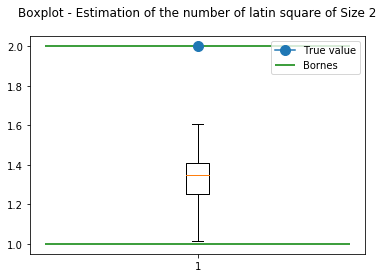

CPU times: user 19.9 s, sys: 15 ms, total: 19.9 s
Wall time: 20 s


In [0]:
%%time 
est2 = get_estimates(100, 2, 100, 20)
viz_estimate(est2, 2, 2)

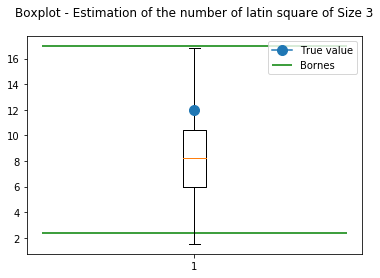

CPU times: user 21.3 s, sys: 28 ms, total: 21.3 s
Wall time: 21.3 s


In [0]:
%%time 
est3 = get_estimates(100, 3, 100, 20)
viz_estimate(est3, 3, 12)

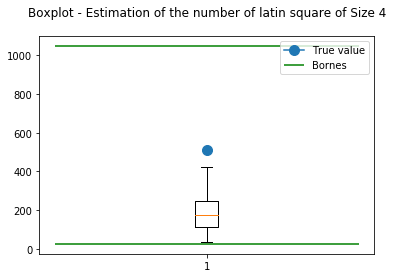

CPU times: user 23.4 s, sys: 9.93 ms, total: 23.4 s
Wall time: 23.5 s


In [0]:
%%time 
est4 = get_estimates(100, 4, 100, 20)
viz_estimate(est4, 4, 512)

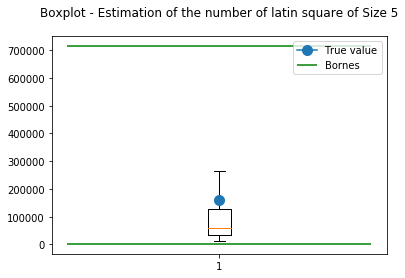

CPU times: user 24.5 s, sys: 21 ms, total: 24.5 s
Wall time: 24.6 s


In [0]:
%%time 
est5 = get_estimates(100, 5, 100, 20)
viz_estimate(est5, 5, 161280)

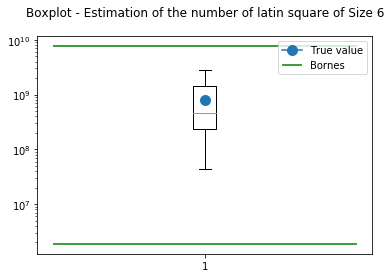

CPU times: user 27.2 s, sys: 17 ms, total: 27.2 s
Wall time: 27.2 s


In [0]:
%%time 
est6 = get_estimates(100, 6, 100, 20)
viz_estimate(est6, 6, 812851200)

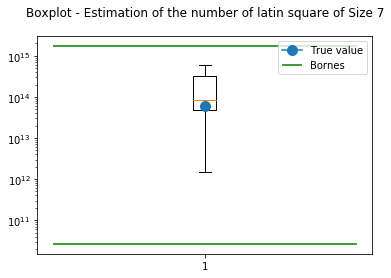

CPU times: user 29 s, sys: 47 ms, total: 29.1 s
Wall time: 29.1 s


In [0]:
%%time 
est7 = get_estimates(100, 7, 100, 20)
viz_estimate(est7, 7, 61479419904000)

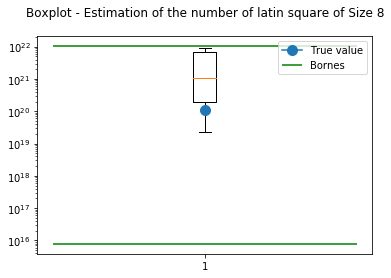

CPU times: user 31.8 s, sys: 23 ms, total: 31.8 s
Wall time: 31.9 s


In [0]:
%%time 
est8 = get_estimates(100, 8, 100, 20)
viz_estimate(est8, 8, 108776032459082956800)

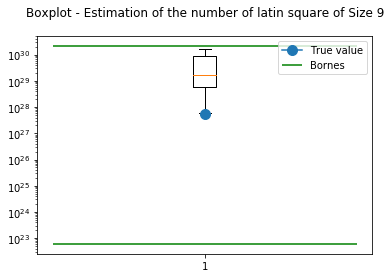

CPU times: user 34 s, sys: 48 ms, total: 34.1 s
Wall time: 34.1 s


In [0]:
%%time 
est9 = get_estimates(100, 9, 100, 20)
viz_estimate(est9, 9, 5524751496156892842531225600)

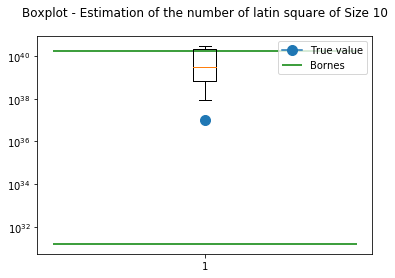

CPU times: user 36.3 s, sys: 19 ms, total: 36.3 s
Wall time: 36.4 s


In [0]:
%%time 
est10 = get_estimates(100, 10, 100, 20)
viz_estimate(est10, 10, 9982437658213039871725064756920320000)

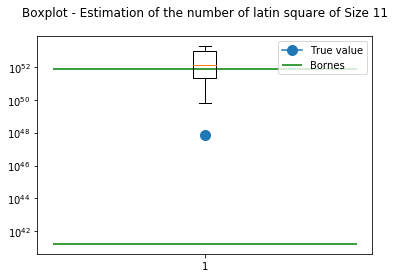

CPU times: user 38.7 s, sys: 16 ms, total: 38.7 s
Wall time: 38.8 s


In [0]:
%%time 
est11 = get_estimates(100, 11, 100, 20)
viz_estimate(est11, 11, 776966836171770144107444346734230682311065600000)

Les echelles des valeurs valeurs étant très grandes, nous pouvons regarder les ratios entre valeurs estimée et valeurs réelles pour avoir une meilleure idée de l'erreur comise. Notre estimateur est pris comme la mediane des estimateurs sur 100 itérations de l'algorithme.

In [0]:
err11 = np.median(est11)/776966836171770144107444346734230682311065600000
err10 = np.median(est10)/9982437658213039871725064756920320000
err9 = np.median(est9)/5524751496156892842531225600
err8 = np.median(est8)/108776032459082956800
err7 = np.median(est7)/61479419904000
err6 = np.median(est6)/812851200
err5 = np.median(est5)/161280
err4 = np.median(est4)/576
err3 = np.median(est3)/12
err2 = np.median(est2)/2

In [0]:
print("Ratio estimator over true value for size 2 :", err2)
print("Ratio estimator over true value for size 3 :", err3)
print("Ratio estimator over true value for size 4 :", err4)
print("Ratio estimator over true value for size 5 :", err5)
print("Ratio estimator over true value for size 6 :", err6)
print("Ratio estimator over true value for size 7 :", err7)
print("Ratio estimator over true value for size 8 :", err8)
print("Ratio estimator over true value for size 9 :", err9)
print("Ratio estimator over true value for size 10 :", err10)
print("Ratio estimator over true value for size 11 :", err11)

Ratio estimator over true value for size 2 : 0.646004837698544
Ratio estimator over true value for size 3 : 0.6592541422243982
Ratio estimator over true value for size 4 : 0.3134923974803898
Ratio estimator over true value for size 5 : 0.3189446120221093
Ratio estimator over true value for size 6 : 0.5195107296284337
Ratio estimator over true value for size 7 : 1.3800546164932208
Ratio estimator over true value for size 8 : 9.252102741816804
Ratio estimator over true value for size 9 : 38.322062055357115
Ratio estimator over true value for size 10 : 482.63617309612044
Ratio estimator over true value for size 11 : 18780.302925405926


In [0]:
%%time 
l = LatinSquarePTemp(11, 100)
for t in range(1000):
    l.smc_temp(20)
l.compute_estimate()

1.9664335478580416e+52

In [0]:
%%time 
l = LatinSquarePTemp(11, 100)
for t in range(1000):
    l.smc_temp(20)
l.compute_estimate()

CPU times: user 6min 20s, sys: 5.95 s, total: 6min 26s
Wall time: 6min 26s


In [0]:
l.compute_estimate()

9.319824885444723e+52

**Conclusion** \\
On remarque que cette méthode est moins précise pour les petites dimensions (en gardant des temps de calculs rapides) mais donne beaucoup plus de satisfaction pour les dimensions 5 et 6. \\
Nos expériences montrent que, comme expliqué en cours, le choix de la séquence des lambda est crucial, il a un fort impact sur la performance. Nous l'avons choisit empiriquement par taton.

# Méthode IBIS

**Méthodologie** 
Nous présentons ici notre algorithme IBIS où nous utilisons la même méthode pour générer de nouvelles matrices et la même fonction de pénalisation. Nous prenons comme poids $w_t^n = e^{-\lambda_{t}*S(M)}$
* 1) **Initialisation : t = 0** : 

*   Générer $\Theta_0^n \sim M_0(dx_0)$
*   Calculer $w_0^n$ = $G_0(\Theta_0^n)$ et $W_0^n = \frac{w_0^n}{\sum_{m=0}^{N}w_0^m}$ et $l_0^N = \frac{1}{N}\sum_{n=1}^Nw_0^n$

On tire une matrice initialisée qui est une permutation. A partir de ça, on génère des poids. $G$ est le noyau. $N$ est le nombre de particules (nombre de matrices sur lequel on applique la procédure). 


* 2) **Itérativement pour t = 1,...,T** : 

*   Si le critère de dégénérescence n'est pas rempli, $ESS > \frac{N}{2} $ : 
      * 1) Poser $\Theta_t^n$ = $\Theta_{t-1}^n$ 
      * 2) Calculer $w_t^n$ = $w_{t-1}^nG(\Theta_t^n)$, $W_t^n = \frac{w_t^n}{\sum_{m=0}^{N}w_t^m}$ et  $l_t^N = \frac{1}{N}\sum_{n=1}^Nw_t^n$

*   Si le critère de dégénérescence est rempli, $ESS \leq \frac{N}{2} $ :  
      * 1) Générer des ancêtres $A_t^n \in 1:N$ indépendamment avec $M(W_{t-1}^{1:N})$ ($M$ correspond à une loi multinomiale) 
      * 2) Générer $\Theta_t^n \sim M_t$($\Theta_{t-1}^{A_t^n}$,$d\theta$) 
      * 3) Calculer $w_t^n$ = $G(\Theta_t^n)$, $W_t^n = \frac{w_t^n}{\sum_{m=0}^{N}w_t^m}$ et  $l_t^N = \frac{1}{N}\sum_{n=1}^Nw_t^n$

  A cette étape, pour chacune des itérations, on calcule l'ESS (qui se définit comme ESS = $\frac{1}{\sum_{n=1}^N (W_t^n)^2}$) et on applique la procédure. A chaque étape on calcule un $L_t$ à partir du $l_t$ (moyenne des poids). On calcule ensuite le $P$ qui est la proportion de carrés latins pour la dimension souhaitée. La constance $C$ est un estimateur du nombre de carrés latins. 
      
**Calcul constante normalisation** 
Une fois l'algorithme terminé, On calcule notre constante C : 
* 1) $L_t$ = $\frac{1}{l_t^N}$
* 2) P = $\prod_{i=1}^T\frac{L_{i-1}}{L_{i}}$ 
* 3) C = $k!^k*P$

C : l'estimateur du nombre de carrés latins. 
Les poids  = la pénalisation (éloignement du fait d'être un carré latin). A l'étape suivante, on a une probabilité suivante plus importante de choisir une matrice avec poids élevés.


In [0]:
class LatinSquareSMC:
    """ size : int, size of latin square. k for k X k squares.
        sample_size : number of particules at time 0
    """

    def __init__(self, size, sample_size):
        self.size = size 
        self.sample = np.array([list(np.random.permutation(size) for i in range(size)) for n in range(sample_size)])
        self.estimators = []
        self.sample_size = sample_size
        self.ess = []
        self.true_values = {2:2, 3:12, 4:576, 5:161280, 6:812851200, 7:61479419904000, 8:108776032459082956800, 9:5524751496156892842531225600, 
                            10:9982437658213039871725064756920320000, 11:776966836171770144107444346734230682311065600000}

    def S(self, square):
       
        s = 0
        for j in range(self.size):
            n_unique = len(set(square[:, j]))
            s += self.size - n_unique 
        return s 

    def G(self, square, lbd):
        
        return np.exp( - lbd * self.S(square))

    def init_weights(self, lbd):
        
        self.weights = np.array([self.G(self.sample[i], lbd) for i in range(self.sample_size)])
        self.normalized_weights = self.weights / np.sum(self.weights)
        self.ess.append(1./ np.sum(np.square(self.normalized_weights)))

    def update_weights(self, lbd, degen=False):
        
        if degen: 
            new_weights = np.array([self.G(self.sample[i], lbd) * self.weights[i] for i in range(self.sample_size)])
            self.weights = new_weights
            self.normalized_weights = self.weights / np.sum(self.weights)
        else:
            self.weights = np.array([self.G(self.sample[i], lbd) for i in range(self.sample_size)])
            self.normalized_weights = self.weights / np.sum(self.weights)
    
    def L_estimator(self):
        
        self.estimators.append(np.mean(self.weights))

    def get_cell(self, point, square):
        
        return square[point[0], point[1]]

    def set_cell(self, point, value, square):
       
        square[point[0], point[1]] = value
        return square 

    def M_kernel(self, square, new_lbd, old_lbd):
        idx = [i for i in range(self.size)]
        cols = np.random.choice(idx, 2, replace = False)
        row = np.array(list(np.random.choice(idx, 1)) * 2)
        positions = list(zip(row, cols))
        v1, v2 = square[row[0], cols[0]], square[row[1], cols[1]]
        new_square = square.copy()
        new_square[row[0], cols[0]] = v2
        new_square[row[1], cols[1]] = v1
        
        old_energy = self.S(square)
        new_energy = self.S(new_square)
        acceptance = min(1, np.exp(- (new_lbd - old_lbd) * (old_energy - new_energy)))
        
        u = np.random.uniform()
        if u <= acceptance:
            return new_square
        return square
    
    def transition(self, old_lbd, new_lbd):
       
        ancestors = np.random.multinomial(self.sample_size, list(self.normalized_weights))
        #les carrés qui ont des grands poids vont avoir plus d'enfants que les autres 
        new_sample = []
        for i in range(self.sample_size):
            for k in range(ancestors[i]):
                new_sample.append(self.M_kernel(self.sample[i], new_lbd, old_lbd))
        self.sample = np.array(new_sample)

    def move_forward(self, n_iter, lbd):
        
        self.mcmc_step = 0
        lbds = [0, 0.001, 0.009, 0.0015, 0.00243, 0.0030, 0.0035, 0.0044, 0.0053, 0.0072, 0.0111, 0.02, 0.025, 0.03, 0.05, 0.067, 0.08, 0.14, 0.37, 0.6, 1, 1.6, 1.8, 2]
        t_l = 1
        for t in range(1, n_iter):
            if t_l == len(lbds):
                break
            if self.ess[-1] <= self.sample_size/2: #DEGENERANCY SATISFIED
                self.transition(lbds[t_l-1], lbds[t_l])
                self.update_weights(lbds[t_l], degen=False)
                self.L_estimator()
                self.mcmc_step += 1
                t_l += 1
            else:
                self.sample = self.sample #theta_(t) = theta_(t-1)
                self.update_weights(lbds[t_l], degen=True)
                self.L_estimator()
                self.ess.append(1./ (np.sum(np.square(self.normalized_weights) + 1e-6)))
    
    def compute_estimate(self, diag=False):
        lts = np.array(self.estimators)
        lts = np.array([e for e in lts if e > 1e-50])
        lts = 1/lts
        prod = 1
        for i in range(1, len(lts)):
            prod *=  lts[i]/lts[i-1] 

        estimate = prod * (math.factorial(self.size)**self.size)
        #print("Estimate is :", estimate)
        if diag:
            print("---- Diagnosis ----")
            print("Number of MCMC step :", self.mcmc_step)
            print("________________")
            plt.plot(self.ess, label="ESS")
            plt.axhline(y=self.sample_size/2, color='r', linestyle='-', label="Resampling treshold")
            plt.legend()
            plt.xlabel("Iteration")
            plt.ylabel("ESS")
            plt.title("ESS")
            plt.show()
            print("________________")
            print("Proportion estimated is :", prod)
            if self.size in self.true_values:
                print("True proportion is :", self.true_values[self.size]/(math.factorial(self.size)**self.size))
        return estimate

---- Diagnosis ----
Number of MCMC step : 6
________________


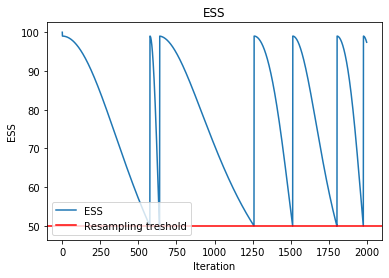

________________
Proportion estimated is : 1.3959223699587986
True proportion is : 0.001736111111111111


463133.54021545034

In [68]:
l = LatinSquareSMC(4, 100)
l.init_weights(0)
l.move_forward(2000, 1)
l.compute_estimate(diag=True)

---- Diagnosis ----
Number of MCMC step : 23
________________


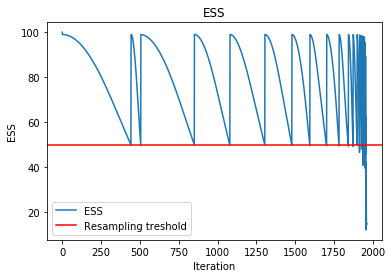

________________
Proportion estimated is : 487.2076067633743
True proportion is : 6.481481481481481e-06


12123284320614.396

In [69]:
l = LatinSquareSMC(5, 100)
l.init_weights(0)
l.move_forward(2000, 1)
l.compute_estimate(diag=True)

---- Diagnosis ----
Number of MCMC step : 23
________________


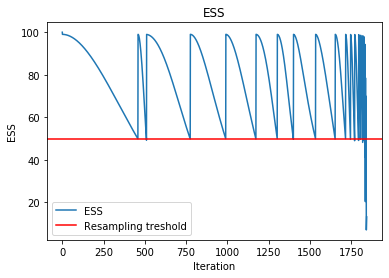

________________
Proportion estimated is : 551.5727862224425
True proportion is : 5.8346669714982474e-09


7.684184947630829e+19

In [71]:
l = LatinSquareSMC(6, 100)
l.init_weights(0)
l.move_forward(2000, 1)
l.compute_estimate(diag=True)

**Conclusion** 
Nos résultats pour cet algorithme sont absurdes, c'est pourquoi nous suspectons une mauvaise implémentation de la méthode. Nous n'avons pas réussi à régler ce problème.